In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

E:\Anaconda\envs\vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 27s 0us/step


In [3]:
"""After downloading, you should now have a copy of the dataset available. There are around 3,675 total images:"""
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


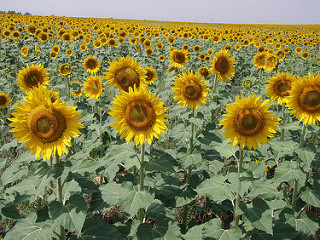

In [13]:
"""Displalying some images"""
# flowers_photos/
#   daisy/
#   dandelion/
#   roses/
#   sunflowers/
#   tulips/
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[2]))

### Load data using a Keras utility

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
"""It's good practice to use a validation split when developing your model. 
Use 80% of the images for training and 20% for validation."""
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
"""You can find the class names in the class_names attribute on these datasets.
These correspond to the directory names in alphabetical order."""
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data
Here are the first nine images from the training dataset:

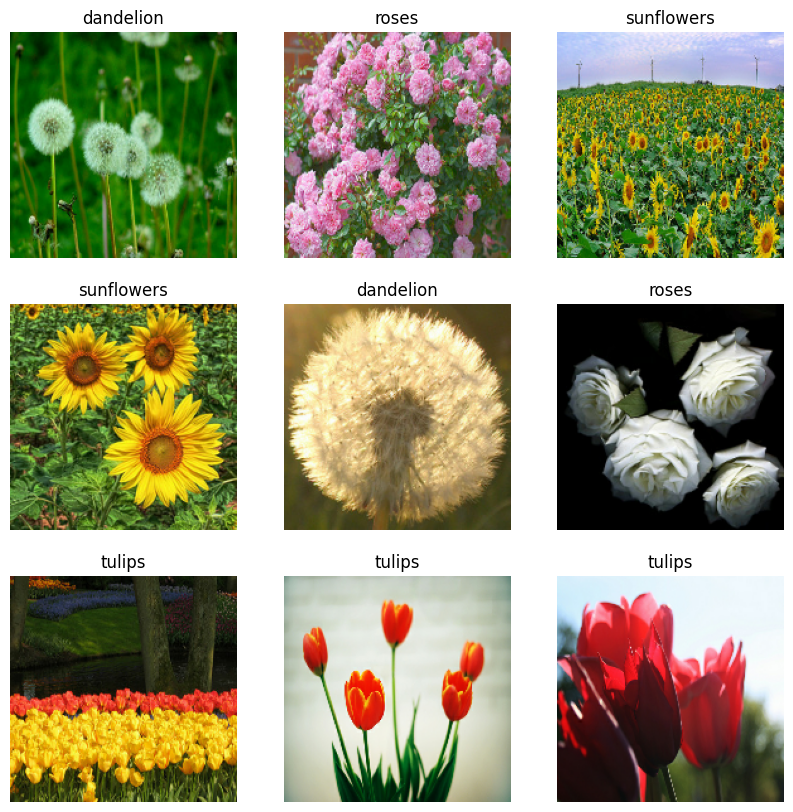

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)

(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 

## Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
"""There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:"""
""""""
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Creation:
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [22]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

## Compile the Model
For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [25]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Train the model
Train the model for 3 epochs with the Keras Model.fit method:

In [26]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 42s 452ms/step - loss: 1.3078 - accuracy: 0.4384 - val_loss: 1.1011 - val_accuracy: 0.5204
Epoch 2/3
92/92 [==============================] - 42s 451ms/step - loss: 1.0285 - accuracy: 0.5926 - val_loss: 1.0174 - val_accuracy: 0.5926
Epoch 3/3
92/92 [==============================] - 42s 452ms/step - loss: 0.8732 - accuracy: 0.6618 - val_loss: 0.9235 - val_accuracy: 0.6390


In [27]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [28]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\gyleo\\.keras\\datasets\\flower_photos\\dandelion\\7262863194_682209e9fb.jpg'
b'C:\\Users\\gyleo\\.keras\\datasets\\flower_photos\\roses\\172311368_49412f881b.jpg'
b'C:\\Users\\gyleo\\.keras\\datasets\\flower_photos\\tulips\\13529687904_3d60abb479_n.jpg'
b'C:\\Users\\gyleo\\.keras\\datasets\\flower_photos\\daisy\\4117918318_3c8935289b_m.jpg'
b'C:\\Users\\gyleo\\.keras\\datasets\\flower_photos\\dandelion\\163702807_e508544acd_n.jpg'


In [29]:
"""Printing Class names"""
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [30]:
"""Split the dataset into training and validation sets:"""
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [31]:
"""Number of records for each"""
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short functions that converts a file path to an (img, label) pair:

In [32]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [33]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [37]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Use Dataset.map to create a dataset of image, label pairs:

In [38]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### Configure dataset for performance
To train a model with this dataset you will want the data:

To be well shuffled.
To be batched.
Batches to be available as soon as possible.

In [39]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualize the data
You can visualize this dataset similarly to the one you created previously:

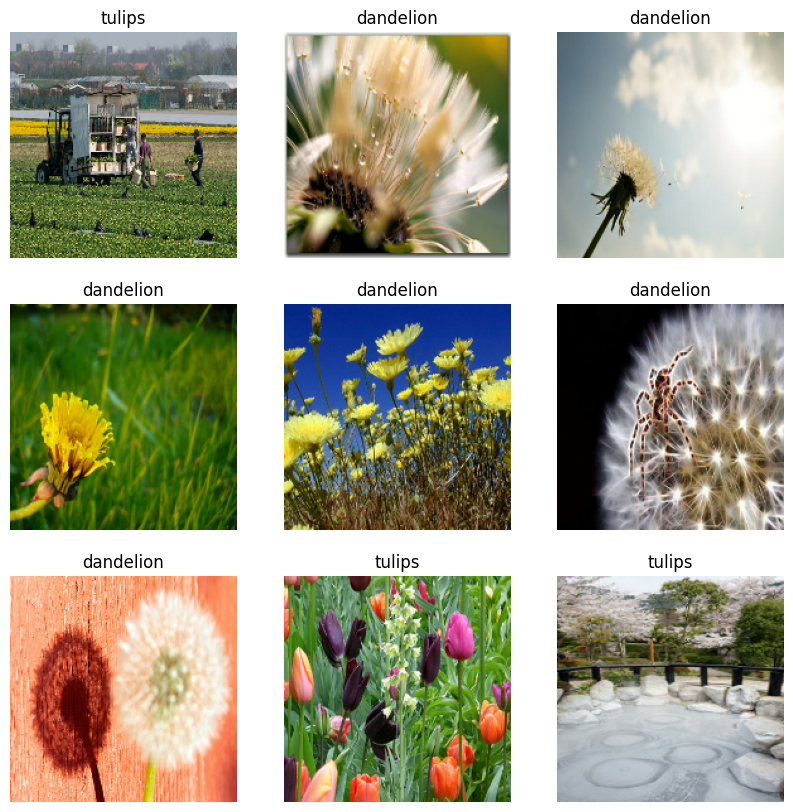

In [41]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Continue Training the model

In [49]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 45s 470ms/step - loss: 0.8037 - accuracy: 0.6880 - val_loss: 0.7830 - val_accuracy: 0.6907
Epoch 2/3
92/92 [==============================] - 43s 468ms/step - loss: 0.6644 - accuracy: 0.7599 - val_loss: 0.7392 - val_accuracy: 0.7248
Epoch 3/3
92/92 [==============================] - 43s 465ms/step - loss: 0.4708 - accuracy: 0.8232 - val_loss: 0.7911 - val_accuracy: 0.7071
